# Control of a "spacecraft" platform with a reaction wheel

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
from scipy import linalg
import sympy as sym
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_platform

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_platform)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create an instance of the robot simulator. This will open a window in which you should see the reaction wheel.

There are four optional parameters:

* `damping` is the coefficient of viscous friction at each joint (the default value is `0.`)
* `pitch` is the angle of the ground in radians (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.001`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
robot = ae353_platform.RobotSimulator(damping=0., pitch=1.57, dt=0.01, display=True)

Define and create an instance of the robot controller. By default, it chooses to apply zero torque to the wheel. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [11]:
class RobotController:
    def __init__(self, dt=0.01, K=np.array([[0., 0.]])):
        self.dt = dt
        
        # Choose equilibrium point
        self.q_e = np.pi
#         self.q_e = 0.
        self.v_e = 0.
        self.v_wheel_e = 0.
        self.tau_e = 0.
        
        # Choose state feedback gains
        self.K = np.array([[13.4525, 8.5229, 0.0765]])
#         self.K = np.array([[2.0000000000000004, 3.0]])
    
    def run(self, q, v, q_wheel, v_wheel):
        """
        INPUTS
         q = angle of platform (rad)
         v = angular velocity of platform (rad/s)
         q_wheel = angle of wheel with respect to platform (rad)
         v_wheel = angular velocity of wheel with respect to platform (rad/s)
        
        OUTPUTS
         tau = torque applied to wheel by motor on platform (N m)
        """
        
        # find x
#         x = np.array([[q - self.q_e], [v - self.v_e]])
        x = np.array([[q - self.q_e], [v - self.v_e], [v_wheel - self.v_wheel_e]])
        
        # find u
        u = - self.K @ x
        
        # find the torque that we want applied to the platform
        tau_on_platform = u[0, 0] + self.tau_e
        
        
#         tau = -10. * (q - self.q_e) - 10. * (v - self.v_e) + 5. * (v_wheel - self.v_wheel_e)
#         tau = 0.
        
        # find the torque that would have to be applied to the wheel
        tau = - tau_on_platform
#         tau = 0.
        
        return tau

controller = RobotController(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get a sensor measurement
* choose an actuator command
* go forward one time step

We also log data so that we can plot it later, if we want.

In [12]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = np.pi + 0.05
# q_platform = 0.25
q_wheel = 0.
v_platform = 0.1
v_wheel = -0.5

# q_platform = 0.5
# q_wheel = 0.
# v_platform = 0.
# v_wheel = 0.



# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

# - could also use:
#
#       robot.reset()
#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q, v, q_wheel, v_wheel = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q, v, q_wheel, v_wheel)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q
    data['v'][step] = v
    data['q_wheel'][step] = q_wheel
    data['v_wheel'][step] = v_wheel
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

Plot the results.

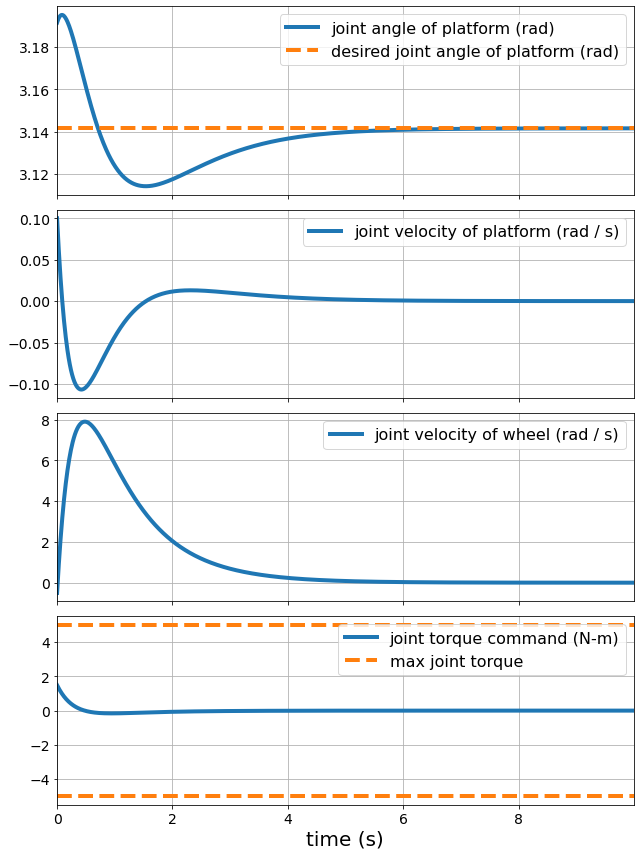

In [13]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# Plot joint angle of platform on first subplot
ax[0].plot(data['t'], data['q'], label='joint angle of platform (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q_e, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot joint velocity of platform on second subplot
ax[1].plot(data['t'], data['v'], label='joint velocity of platform (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot joint velocity of wheel on third subplot
ax[2].plot(data['t'], data['v_wheel'], label='joint velocity of wheel (rad / s)', linewidth=4)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Plot joint torque on fourth subplot
ax[3].plot(data['t'], data['tau'], label='joint torque command (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C1')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()